In [2]:
from MiniTorch.nets.base import Net
from MiniTorch.nets.layers import Conv2D, Linear, MaxPool2d, PReLU, ReLU, SoftMax, Flatten
from MiniTorch.optimizers import SGD
from MiniTorch.losses import CCE
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

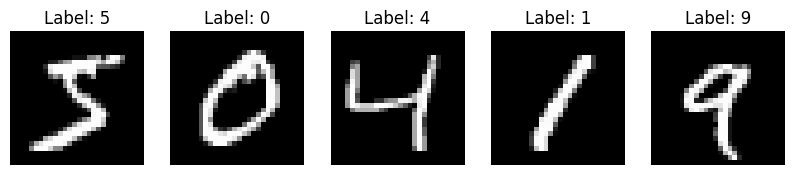

In [4]:
X = X.to_numpy()
y = y.to_numpy()
n_samples = X.shape[0]
image_size = (28, 28)
X_images = X.reshape(n_samples, 28,28)



def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
plot_sample_images(X_images, y, num_samples=5)

In [5]:
def get_training_data(X,Y,train_size):
    X_tra = X[:train_size]
    Y_tra = Y[:train_size]
    Y_tra = [[1 if j == int(i) else 0 for j in range(10)] for i in Y_tra]
    Y_tra = jnp.array(Y_tra)
    X_tra = jnp.reshape(jnp.array(X_tra),(train_size, 28,28))
    X_tra = jnp.expand_dims(X_tra,axis = 1)
    X_tra = X_tra.astype('float32')/255.
    return X_tra,Y_tra
X_tra, Y_tra = get_training_data(X,y,40000)

In [6]:
net = Net(
    [
        Conv2D(1,4,20, accumulate_grad_norm=True, accumulate_params=True, initialization='he'),
        MaxPool2d(2,1),
        Flatten(),
        Linear(11520, 50, accumulate_grad_norm=True,accumulate_parameters=True,initialization='he'),
        PReLU(accumulate_grad_norm=True,accumulate_parameters=True),
        Linear(50, 10,accumulate_grad_norm=True,accumulate_parameters=True,initialization='he'),
        SoftMax()
    ],
    reproducibility_key=20
)

In [7]:
def yield_batches(X, Y, batch_size):
    """
    Yields batches of data and labels of the specified batch size.
    
    Args:
        X (numpy.ndarray): Input data array of shape (n_samples, ...) where ... is the feature shape.
        Y (numpy.ndarray): Label array of shape (n_samples, ...).
        batch_size (int): Size of each batch.
    
    Yields:
        tuple: (batch_X, batch_Y) where each is a slice of X and Y of size batch_size
               (or smaller for the last batch if n_samples % batch_size != 0).
    """
    n_samples = X.shape[0]
    
    # Ensure X and Y have compatible shapes
    assert n_samples == Y.shape[0], "Number of samples in X and Y must match"
    
    # Iterate over the dataset in chunks of batch_size
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        yield X[start_idx:end_idx], Y[start_idx:end_idx]

In [9]:
epochs = 20
batch_size = 1000
crit = CCE()
optimizer = SGD(0.001,net)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X_tra,Y_tra,1000):
        pred = net.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

Loss for 0/20 -> 0.707603931427002


In [23]:
net.print_variance_info()

Linear 0
Weights Variance and Mean -> (Array(1.2042918, dtype=float32), Array(-0.01967998, dtype=float32))
Bias Variance and Mean -> (Array(0., dtype=float32), Array(0., dtype=float32))
Input Variance and Mean -> (Array(0.0919449, dtype=float32), Array(0.126595, dtype=float32))
Output Variance and Mean -> (Array(2.1836693, dtype=float32), Array(-0.04955678, dtype=float32))
Linear 3
Weights Variance and Mean -> (Array(1.0046912, dtype=float32), Array(-0.00155826, dtype=float32))
Bias Variance and Mean -> (Array(0., dtype=float32), Array(0., dtype=float32))
Input Variance and Mean -> (Array(2.3327687, dtype=float32), Array(0.5879611, dtype=float32))
Output Variance and Mean -> (Array(29116.602, dtype=float32), Array(-6.072758, dtype=float32))
Relu 4
Input Variance and Mean -> (Array(29116.602, dtype=float32), Array(-6.072758, dtype=float32))
Output Variance and Mean -> (Array(12477.077, dtype=float32), Array(46.308186, dtype=float32))
Linear 5
Weights Variance and Mean -> (Array(1.035388

In [12]:
net.print_variance_info()

Conv2D 0
Weights Variance and Mean -> (Array(0.00752682, dtype=float32), Array(-0.00155584, dtype=float32))
Bias Variance and Mean -> (Array(4.3216918e-16, dtype=float32), Array(1.7102781e-09, dtype=float32))
Input Variance and Mean -> (Array(0.09756193, dtype=float32), Array(0.13768007, dtype=float32))
Output Variance and Mean -> (Array(0.01408566, dtype=float32), Array(-0.00429924, dtype=float32))
Linear 3
Weights Variance and Mean -> (Array(0.00017372, dtype=float32), Array(7.734418e-06, dtype=float32))
Bias Variance and Mean -> (Array(1.10897074e-16, dtype=float32), Array(6.955882e-10, dtype=float32))
Input Variance and Mean -> (Array(0.01489527, dtype=float32), Array(0.03986484, dtype=float32))
Output Variance and Mean -> (Array(0.03470171, dtype=float32), Array(-0.03303762, dtype=float32))
PReLU 4
Input Variance and Mean -> (Array(0.03470171, dtype=float32), Array(-0.03303762, dtype=float32))
Output Variance and Mean -> (Array(0.01253102, dtype=float32), Array(0.03966644, dtype=f

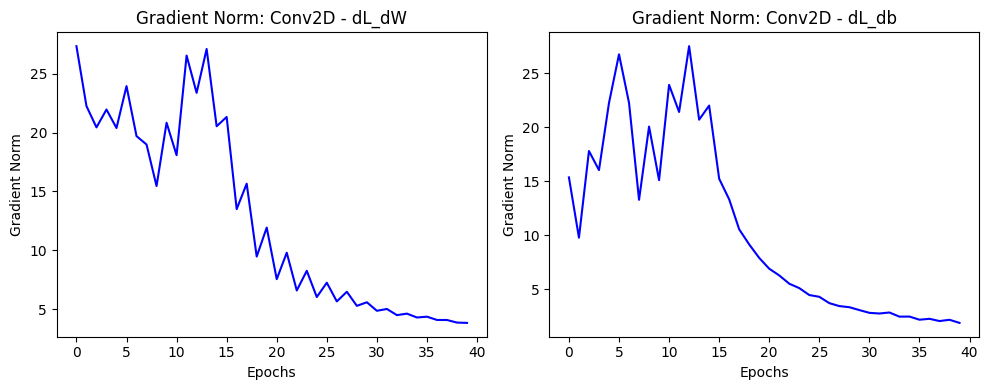

In [27]:
net.layers[0].plot_grad_norm()

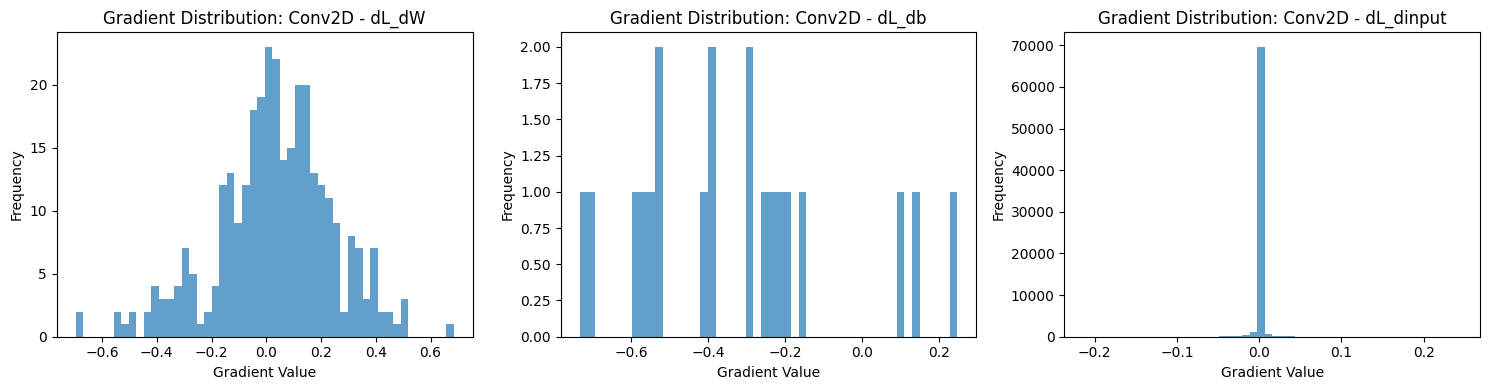

In [28]:
net.layers[0].plot_grad_dist()

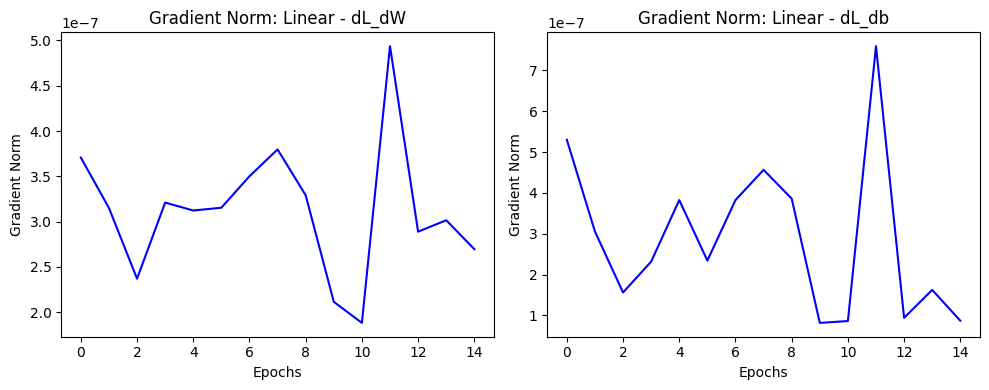

In [22]:
net.layers[-2].plot_grad_norm()

In [26]:
pred = net.forward(X_images)
loss = crit.loss(pred,Y)

In [27]:
ini_grad = crit.backward()

In [29]:
n_grad = net.layers[-1].backward(ini_grad)

In [31]:
n2_grad = net.layers[-2].backward(n_grad)

In [38]:
n3_grad = net.layers[-3].backward(n2_grad)

In [ ]:
n3_grad.

Array(0.0213101, dtype=float32)

In [47]:
float(net.layers[-2].grad_cache['dL_dW'].var())

0.30466559529304504

In [35]:
net.print_gradient_info()

In [36]:
net.layers[0].grad_cache

{}

In [ ]:
net.la

Array([[0.08994269, 0.06616123, 0.16419159, 0.10785104, 0.06971591,
        0.11118355, 0.09949122, 0.08941592, 0.11923791, 0.0828089 ]],      dtype=float32)

In [ ]:
net.layers[-1].backward(ini_grad)

SoftMax(requires_grad=False, _grad_norm={}, _accum_params={}, _accum_param_var_mean={}, grad_cache={'dL_dinput': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, accumulate_grad_norm=False, accumulate_parameters=False)

In [15]:
ini_grad = crit.backward()

In [17]:
ini_grad

Array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        -10.351883,   0.      ,   0.      ,   0.      ,   0.      ]],      dtype=float32)

In [18]:
net.layers[-1].grad_cache

{'dL_dinput': Array([[2.6353767e-08, 2.5144498e-08, 2.5091239e-08, 2.4965079e-08,
         2.1306585e-08, 2.3031422e-08, 2.2559181e-08, 2.3867496e-08,
         2.1693191e-08, 2.4406114e-08]], dtype=float32)}

In [19]:
import jax.numpy as jnp
p = jnp.array([[0.0899, 0.0662, 0.1642, 0.1079, 0.0697, 0.1112, 0.0995, 0.0894, 0.1192, 0.0828]])
grad = jnp.array([[0, 0, 0, 0, 0, -10.351883, 0, 0, 0, 0]])
result = p * (grad - jnp.sum(p * grad, axis=1, keepdims=True))
print(result)

[[ 0.10348653  0.07620477  0.18901543  0.12420686  0.08023372 -1.0231237
   0.11453737  0.10291097  0.13721462  0.09531351]]
